# Exploring dense matrix multiplication (GEMM)

This notebook uses the fiber-tree emulator to display the behavior of various matrix multiplications for dense data. Because the data is assumed to be dense we use the position-based operators on the premise that for dense data the position and coordinate are the same.

In Einsum notation we will be computing the following:

$$
Z_{m,n} = \sum_k A_{m,k} \times B_{k,n}
$$

First, include some libraries

In [2]:
# Run boilerplate code to set up environment

from copy import deepcopy

%run ../prelude.py --style=compressed --animation=movie

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Unsuppored display style


Button(description='Run all cells below', style=ButtonStyle())

## Matrix Multiplication Input Selections

Use the sliders below to select the shapes of the A and B matrics and tiling. Tiling is expresed by splitting the shape of each rank into two factors, e.g., M1 and M0, where the product is the full shape of the dimension, e.g., M = M1 x M0.

In [3]:
# Initial values

M1 = 2
M0 = 2
K1 = 2
K0 = 2
N1 = 2
N0 = 2

density = [1.0]
seed = 10

enable_log = False

def set_params(**kwargs):
    global enable_log
    
    for variable, value in kwargs.items():
        globals()[variable] = value

    enable_log = (kwargs["log"] == 'enable')


def logger(arg):
    if enable_log:
        print(arg)

controls = interactive(set_params,
                       M1=widgets.IntSlider(min=1, max=4, step=1, value=M1),
                       M0=widgets.IntSlider(min=1, max=4, step=1, value=M0),
                       K1=widgets.IntSlider(min=1, max=4, step=1, value=K1),
                       K0=widgets.IntSlider(min=1, max=4, step=1, value=K0),
                       N1=widgets.IntSlider(min=1, max=4, step=1, value=N1),
                       N0=widgets.IntSlider(min=1, max=4, step=1, value=N0),
                       seed=widgets.IntSlider(min=0, max=100, step=1, value=seed),
                       log=['disable', 'enable'])

display(controls)

interactive(children=(IntSlider(value=2, description='M1', max=4, min=1), IntSlider(value=2, description='M0',…

## Create Input Tensors

Given shapes selected above create and display the filter weights (**f**) and input activations (**i**) and a reference output (**o_verify**)

Input A


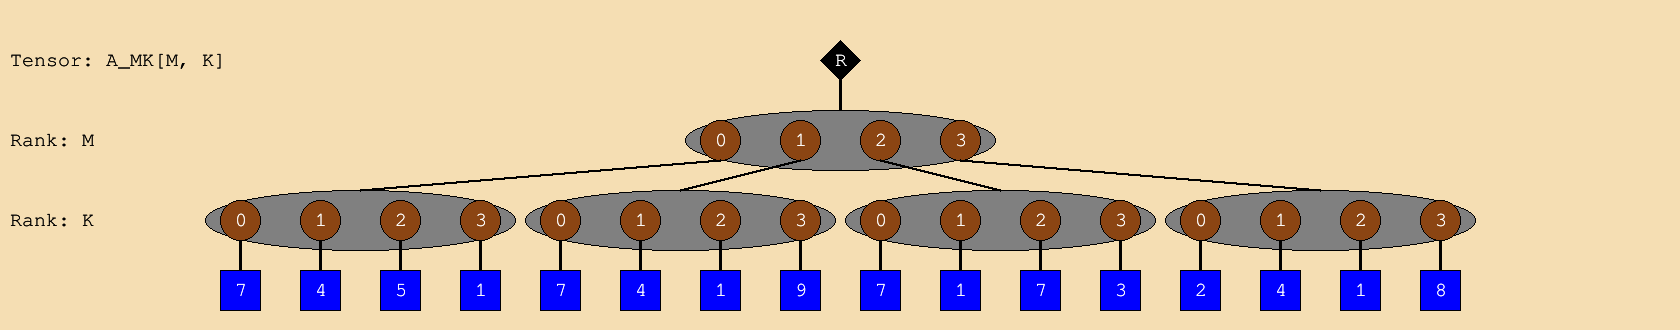

Input B


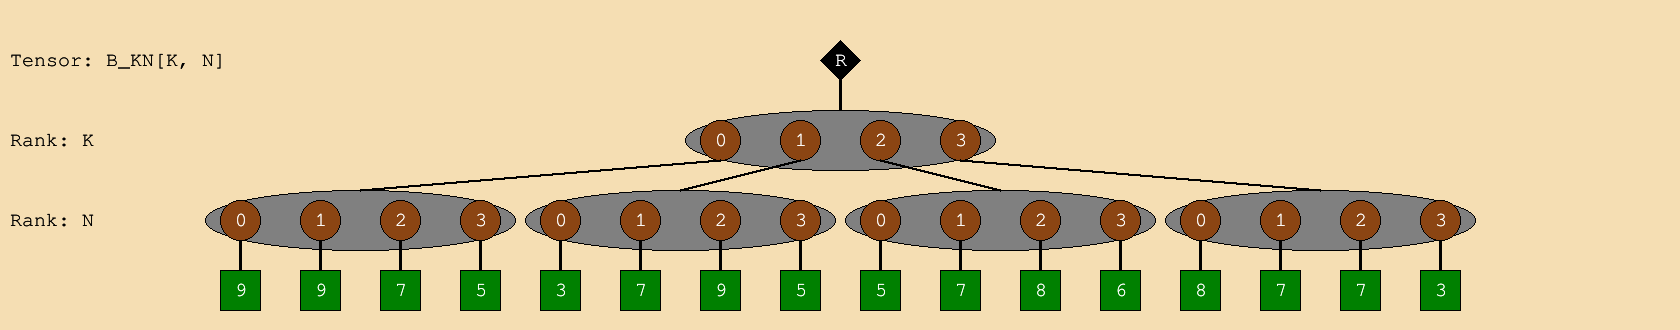

In [4]:
M = M1*M0
K = K1*K0
N = N1*N0

a_MK_raw = []
for m in range(M):
    a_MK_raw.append([random.randint(1, 9) for i in range(K)])

                 
b_KN_raw = []
for k in range(K):
    b_KN_raw.append([random.randint(1, 9) for i in range(N)])

#o_verify_raw = [0 for i in range(Q)]

#for q in range(Q):
#    for s in range(S):
#        w = q+s
#        o_verify_raw[q] += i_raw[w] * f_raw[s]

a_MK = Tensor.fromUncompressed(["M", "K"], a_MK_raw)
b_KN = Tensor.fromUncompressed(["K", "N"], b_KN_raw)

a_MK.setName("A_MK").setColor("blue")
b_KN.setName("B_KN").setColor("green")

print("Input A")
displayTensor(a_MK)
                    
print("Input B")
displayTensor(b_KN)

#
# Create a variable for the result that
# will be populated by the untiled computation below
#
z_verify = None

def create_z():
    z = Tensor(rank_ids=["M", "N"])
    z.setName("Z")
    z.setMutable(True)
    z_m = z.getRoot()
    #
    # Hack to fill in all the entries in z
    # This allows us to pretend the tensor is dense
    #
    n_fiber = Fiber(coords=range(N), initial=1)
    m_fiber = Fiber(coords=range(M), initial=1)
    for m, (z_n, _) in z_m << m_fiber:
        for n, (z_ref, _) in z_n << n_fiber:
            z_ref <<= 1
    return z

## Matrix Multiply

Matrix Multiply


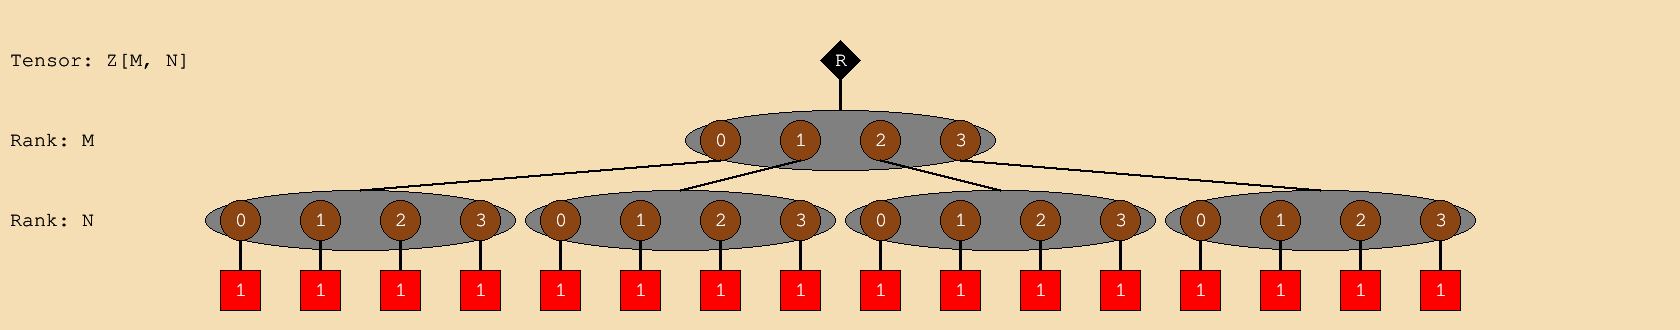

Output - before


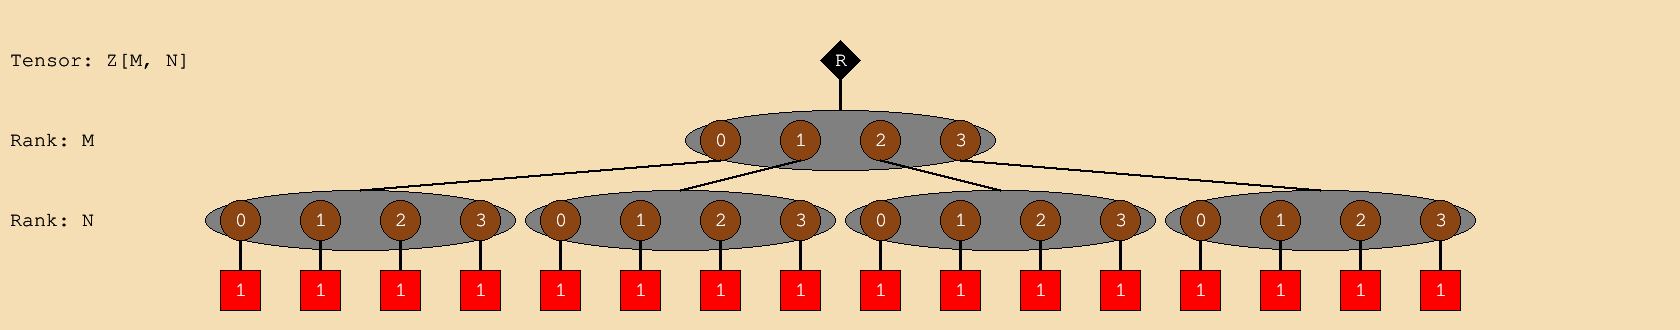

Output - after


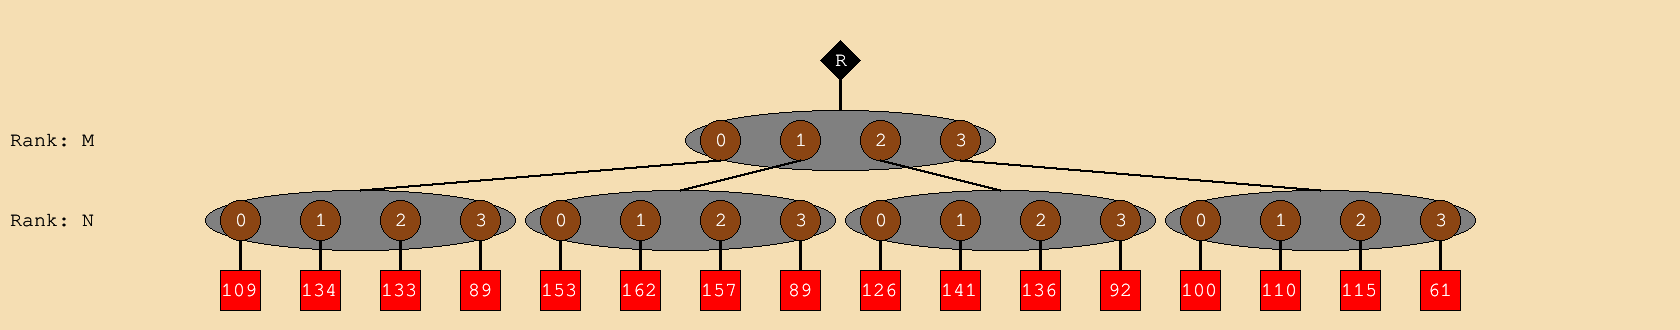

  0%|          | 0/66 [00:00<?, ?it/s]

In [5]:
print("Matrix Multiply")

#
# Create output
#
z_MN = create_z()

displayTensor(z_MN)

print("Output - before")
displayTensor(z_MN)

#
# Get roots
#
z = z_MN.getRoot()
a = a_MK.getRoot()
b = b_KN.getRoot()


canvas = createCanvas(a_MK, b_KN, z_MN)
#
# Traverse Ms
#
for m in range(M):
    #
    # Animation bookkeeping
    #
    a_tile = [ (m, kt) for kt in range(K)]
    #
    # Travere Ns
    #
    for n in range(N):
        logger(f"Processing Z({m},{n}) = {z[m][n].payload}")
        #
        # Animation bookkeeping
        #
        b_tile = [ (kt, n) for kt in range(K)]
        z_tile = (m, n)
        #
        # Traverse Ks
        #
        for k in range(K):
            logger(f"Processing A({m},{k}) = {a[m][k].payload}")
            logger(f"Processing B({k},{n}) = {b[k][n].payload}")
            #
            # Reuduce into output
            #
            z[m][n] += a[m][k] * b[k][n]
            #
            # Animation bookkeeping
            #
            canvas.addActivity(a_tile, b_tile, z_tile, worker="W")
            canvas.addFrame((m,k), (k,n), (m,n))


print("Output - after")
displayTensor(z)

displayCanvas(canvas)

#
# Save result for verification purposes
#
if z_verify is None:
    z_verify = deepcopy(z)


## Tiled Matrix Multiply

Matrix Multiply
Output - before


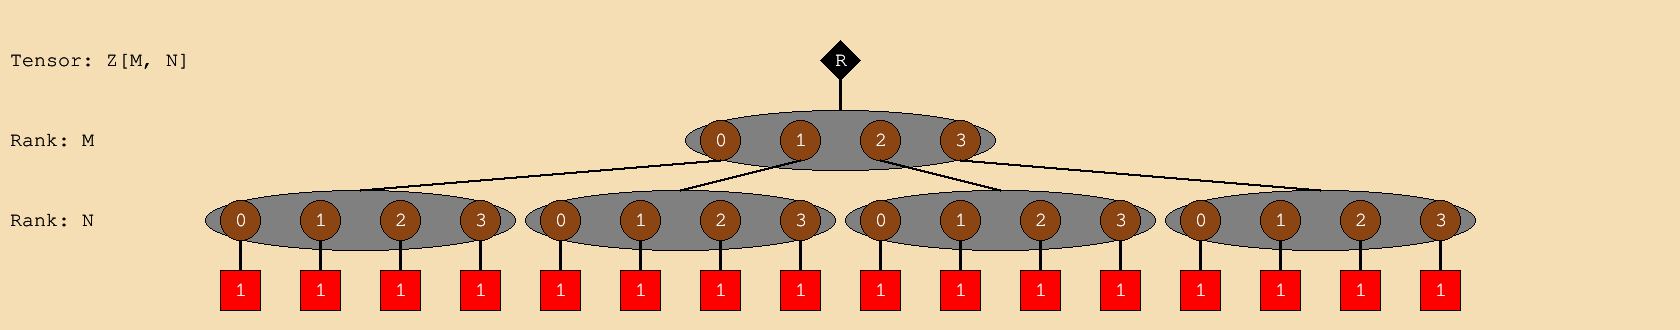

  0%|          | 0/66 [00:00<?, ?it/s]

In [6]:
print("Matrix Multiply")

#
# Create output
#
z_MN = create_z()

print("Output - before")
displayTensor(z_MN)

#
# Get roots
#
z = z_MN.getRoot()
a = a_MK.getRoot()
b = b_KN.getRoot()



canvas = createCanvas(a_MK, b_KN, z_MN)
#
# Traverse Ms
#
for k1 in range(K1):
    #
    # Travere Ns
    #
    for m1 in range(M1):
        logger(f"Processing Z({m},{n}) = {z[m][n].payload}")
        #
        # Traverse Ks
        #
        for n1 in range(N1):
            #
            # Animation bookkeeping
            #
            a_tile = [ (m1*M0+mt, k1*K0+kt) for mt in range(M0)for kt in range(K0)]
            b_tile = [ (k1*K0+kt, n1*N0+nt) for kt in range(K0)for nt in range(N0)]
            z_tile = [ (m1*M0+mt, n1*N0+nt) for mt in range(M0)for nt in range(N0)]

            for m0 in range(M0):
                for n0 in range(N0):
                    for k0 in range(K0):
                        m = m1*M0+m0
                        n = n1*N0+n0
                        k = k1*K0+k0
                        
                        logger(f"Processing A({m},{k}) = {a[m][k].payload}")
                        logger(f"Processing B({k},{n}) = {b[k][n].payload}")
                        #
                        # Reuduce into output
                        #
                        z[m][n] += a[m][k] * b[k][n]
                        #
                        # Animation bookkeeping
                        #
                        #canvas.addActivity(a_tile, b_tile, z_tile, worker="W")
                        canvas.addFrame((m,k), (k,n), (m,n))


#print("Output - after")
#displayTensor(z)

displayCanvas(canvas)

if z_verify is None:
    print("Result not verified")
else:
    assert z == z_verify

## Testing area

For running alternative algorithms